In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [ ]:
# Step 0: Download sentiment lexicon
nltk.download('vader_lexicon')


In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Step 1: Load CSVs
df_reviews = pd.read_csv('Once_Upon_A_Thai_Reviews.csv')
df_tips = pd.read_csv('Latest_Latest_Once_Updated.csv')

In [ ]:
# Step 2: Clean column names
df_reviews.columns = df_reviews.columns.str.strip()
df_tips.columns = df_tips.columns.str.strip()

In [ ]:
# Step 3: Convert 'Date' columns to datetime
df_reviews['Date'] = pd.to_datetime(df_reviews['Date'], dayfirst=True)
df_tips['Date'] = pd.to_datetime(df_tips['Date'], dayfirst=True)


In [ ]:
# Step 4: Fill missing review text
df_reviews['Review_Text'] = df_reviews['Review_Text'].fillna("")


In [ ]:
# Step 5: Group reviews per day
reviews_daily = df_reviews.groupby('Date')['Review_Text'].apply(' '.join).reset_index()

In [ ]:
# Step 6: Merge with tips/sales
df_final = pd.merge(df_tips, reviews_daily, on='Date', how='inner')

In [ ]:
# Step 7: Convert and clean numeric columns
tip_col = 'Tips'
sales_col = 'Total Sales - Food +Soda+Liquor(Before Tax)'

df_final[tip_col] = pd.to_numeric(df_final[tip_col].astype(str).str.replace(',', '').str.replace('$', ''), errors='coerce')
df_final[sales_col] = pd.to_numeric(df_final[sales_col].astype(str).str.replace(',', '').str.replace('$', ''), errors='coerce')


In [ ]:
# Step 8: Calculate tip %
df_final['tip_percent'] = df_final[tip_col] / df_final[sales_col] * 100


In [ ]:
# Step 9: Sentiment analysis
sia = SentimentIntensityAnalyzer()
df_final['Sentiment'] = df_final['Review_Text'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [ ]:
# Step 10: Sort and smooth
df_final = df_final.sort_values('Date')
df_final['tip_percent_smooth'] = df_final['tip_percent'].rolling(window=7).mean()
df_final['sentiment_smooth'] = df_final['Sentiment'].rolling(window=7).mean()

# Correlation: raw and smoothed
correlation_raw = df_final[['tip_percent', 'Sentiment']].corr().iloc[0, 1]
correlation_smooth = df_final[['tip_percent_smooth', 'sentiment_smooth']].corr().iloc[0, 1]

print(f" Correlation between raw Tip % and Sentiment: {correlation_raw:.3f}")
print(f"Correlation between smoothed Tip % and Sentiment: {correlation_smooth:.3f}")


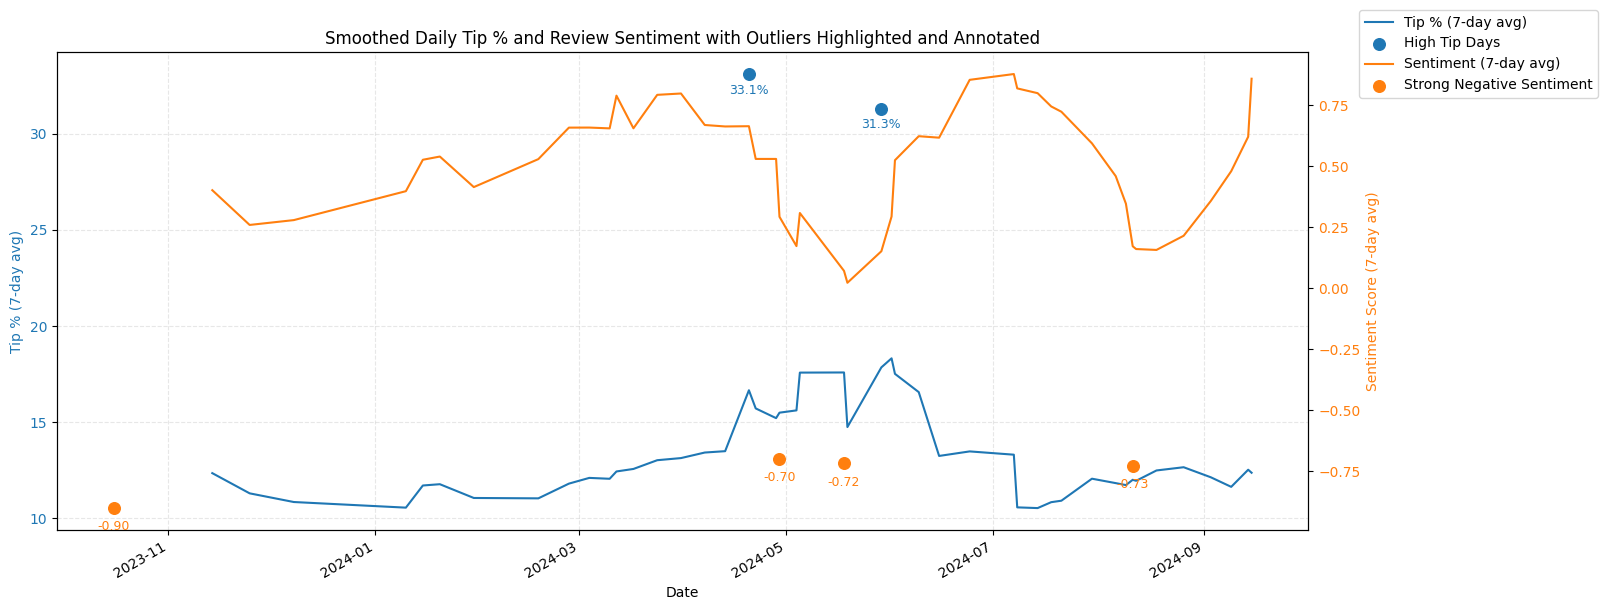

In [19]:
# Step 11: Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

color_tip = 'tab:blue'
color_sent = 'tab:orange'

# Left y-axis: Tip %
ax1.set_xlabel('Date')
ax1.set_ylabel('Tip % (7-day avg)', color=color_tip)
ax1.plot(df_final['Date'], df_final['tip_percent_smooth'], color=color_tip, label='Tip % (7-day avg)')
ax1.tick_params(axis='y', labelcolor=color_tip)
ax1.grid(True, linestyle='--', alpha=0.3)

# Highlight high tip days
high_tip_days = df_final[df_final['tip_percent'] > 30]
ax1.scatter(high_tip_days['Date'], high_tip_days['tip_percent'], color='tab:blue', label='High Tip Days', zorder=5, s=70)

# Annotate high tip %
for _, row in high_tip_days.iterrows():
    ax1.annotate(f"{row['tip_percent']:.1f}%",
                 (row['Date'], row['tip_percent']),
                 textcoords="offset points", xytext=(0, -14),
                 ha='center', fontsize=9, color='tab:blue')

# Right y-axis: Sentiment
ax2 = ax1.twinx()
ax2.set_ylabel('Sentiment Score (7-day avg)', color=color_sent)
ax2.plot(df_final['Date'], df_final['sentiment_smooth'], color=color_sent, label='Sentiment (7-day avg)')
ax2.tick_params(axis='y', labelcolor=color_sent)

# Highlight strong negative sentiment
neg_sentiment_days = df_final[df_final['Sentiment'] < -0.5]
ax2.scatter(neg_sentiment_days['Date'], neg_sentiment_days['Sentiment'], color='tab:orange', label='Strong Negative Sentiment', zorder=5, s=70)

# Annotate negative sentiment
for _, row in neg_sentiment_days.iterrows():
    ax2.annotate(f"{row['Sentiment']:.2f}",
                 (row['Date'], row['Sentiment']),
                 textcoords="offset points", xytext=(0, -16),
                 ha='center', fontsize=9, color='tab:orange')

# Format
fig.autofmt_xdate()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Move legend top-right, outside plot
fig.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper right', bbox_to_anchor=(1.15, 1.02), fontsize=10)

plt.title('Smoothed Daily Tip % and Review Sentiment with Outliers Highlighted and Annotated')
plt.tight_layout()

# Optional: Save plot
# plt.savefig('tip_sentiment_annotated.png', dpi=300, bbox_inches='tight')
plt.show()
